# FRETBursts - μs-ALEX smFRET burst analysis

*This notebook is part of a [tutorial series](https://github.com/tritemio/FRETBursts_notebooks) for the [FRETBursts](http://tritemio.github.io/FRETBursts/) burst analysis software.*

> In this notebook, we present a typical [FRETBursts](http://tritemio.github.io/FRETBursts/) 
> workflow for **μs-ALEX smFRET burst analysis**. 
> Briefly, we show how to perform background estimation, burst search, burst selection, 
> compute FRET histograms and ALEX histograms, do sub-population selection and finally, FRET efficiency fit.


<br>
<div class="alert alert-success">
If you are new to the notebook interface see 
<a href="1. First Steps - Start here if new to Jupyter Notebooks.ipynb">First Steps</a>
before continuing.
</div>

Before running the notebook, you can click on menu *Cell* -> *All Output* -> *Clear* 
to clear all previous output. This will avoid mixing output from current execution and 
the previously saved one.

# Loading the software

We start by loading **`FRETBursts`**:

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.7+0.g7267863.dirty).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


<div class="alert alert-info">
Thanks in advance for remembering to <b>cite</b> FRETBursts in publications or presentations!
</div>

Note that FRETBursts **version string** tells you the exact FRETBursts version (and revision) in use.
Storing the version in the notebook helps with reproducibility and 
tracking software regressions.

Next, we initialize the default plot style for the notebook 
(under the hood it uses [seaborn](http://stanford.edu/~mwaskom/software/seaborn/)):

In [2]:
sns = init_notebook()

Note that the previous command has no output. Finally, we print the version of some dependencies:

In [3]:
import lmfit; lmfit.__version__

'0.9.5'

In [4]:
import phconvert; phconvert.__version__

'0.7.1'

# Downloading the data file

The full list of smFRET measurements used in the [FRETBursts tutorials](https://github.com/tritemio/FRETBursts_notebooks) 
can be found on [Figshare](http://dx.doi.org/10.6084/m9.figshare.1456362).

This is the file we will download:

In [5]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

<div class="alert alert-success">
You can change the <code>url</code> variable above to download your own data file.
This is useful if you are executing FRETBursts online and you want to use
your own data file. See 
<a href="1. First Steps - Start here if new to Jupyter Notebooks.ipynb">First Steps</a>.
</div>

Here, we download the data file and put it in a folder named `data`, 
inside the notebook folder:

In [6]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /Users/anto/src/FRETBursts/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


> **NOTE**: If you modified the `url` variable providing an invalid URL
> the previous command will fail. In this case, edit the cell containing 
> the `url` and re-try the download.

# Selecting the data file

Use one of the following 2 methods to select a data file.

## Option 1: Paste the file-name

Here, we can directly define the file name to be loaded:

In [7]:
filename = "./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"
filename

'./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

Now `filename` contains the path of the file you just selected. 
Run again the previous cell to select a new file. In a following cell
we will check if the file actually exists.

<div class="alert alert-success">
When running the notebook online and using your own data file,
make sure to modify the previous cell. 
<br>
See
<a href="1. First Steps - Start here if new to Jupyter Notebooks.ipynb">First Steps</a>.
</div>

## Option 2: Use an "Open File" dialog

Alternatively, you can select a data file with an "Open File" windows.
Note that, since this only works in a local installation, the next commands
are commented (so nothing will happen when running the cell). 

If you want to try the File Dialog, you need to remove the `#` signs:

In [8]:
# filename = OpenFileDialog()
# filename

## Check that the data file exists

Let's check that the file exists:

In [9]:
import os
if os.path.isfile(filename):
    print("Perfect, file found!")
else:
    print("Sorry, file:\n%s not found" % filename)

Perfect, file found!


# Load the selected file

We can finally load the data and store it in a variable called `d`:

In [10]:
d = loader.photon_hdf5(filename)

If you don't get any message, the file is loaded successfully.

We can also set the 3 correction coefficients: 

* leakage or bleed-through: `leakage`
* direct excitation: `dir_ex` (ALEX-only)
* gamma-factor `gamma`

In [11]:
d.leakage = 0.11
d.dir_ex = 0.04
d.gamma = 1.

> **NOTE:** at any later moment, after burst search, a simple 
> reassignment of these coefficient will update the burst 
> data with the new correction values.

# μs-ALEX parameters

At this point, timestamps and detectors numbers are contained in the `ph_times_t` and `det_t` attributes of `d`. Let's print them:

In [12]:
d.ph_times_t, d.det_t

([array([     146847,      188045,      294124, ..., 47999863658,
         47999877783, 47999955353])],
 [array([0, 1, 1, ..., 1, 1, 0], dtype=uint32)])

We need to define some ALEX parameters: 

In [13]:
d.add(det_donor_accept = (0, 1), 
      alex_period = 4000,
      offset = 700,
      D_ON = (2180, 3900), 
      A_ON = (200, 1800))

Here the parameters are:

- `det_donor_accept`: donor and acceptor channels
- `alex_period`: length of excitation period (in timestamps units)
- `D_ON` and `A_ON`: donor and acceptor excitation windows
- `offset`: the offset between the start of alternation and start of timestamping 
  (see also [Definition of alternation periods](http://photon-hdf5.readthedocs.org/en/latest/phdata.html#definition-of-alternation-periods)).

To check that the above parameters are correct, we need to plot the histogram of timestamps (modulo the alternation period) and superimpose the two excitation period definitions to it:

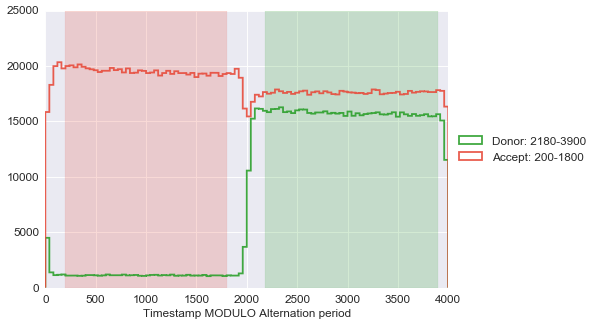

In [14]:
bpl.plot_alternation_hist(d)

If the previous alternation histogram looks correct, 
the corresponding definitions of the excitation periods can be applied to the data using the following command:

In [15]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):   2,259,522
#  D  photons in D+A excitation periods:    721,537
#  A  photons in D+A excitation periods:  1,537,985
# D+A photons in  D  excitation period:   1,434,842
# D+A photons in  A  excitation period:     824,680



If the previous histogram does not look right, the parameters in the `d.add(...)` cell can be modified and checked by running the histogram plot cell until everything looks fine. Don't forget to apply the 
parameters with `loader.usalex_apply_period(d)` as a last step.

> **NOTE:** After applying the ALEX parameters a new array of 
> timestamps containing only photons inside the excitation periods 
> is created (name `d.ph_times_m`). To save memory, by default, 
> the old timestamps array (`d.ph_times_t`) is deleted. Therefore, 
> in the following, when we talk about all-photon selection we always 
> refer to all photons inside both excitation periods.

## Measurement infos

The entire measurement data is now stored in the variable `d`. Printing it
will give a compact representation containing the file-name and additional parameters:

In [16]:
d

data_0023uLRpitc_NTP_20dT_0.5GndCl G1.000 Lk11.000 dir4.0

To check the **measurement duration** (in seconds) run:

In [17]:
d.time_max

599.99943316249994

# Plotting basics

In this section basic concepts of plotting with FRETBursts using the
timetrace plot as an example.

To plot a timetrace of the measurement we use:

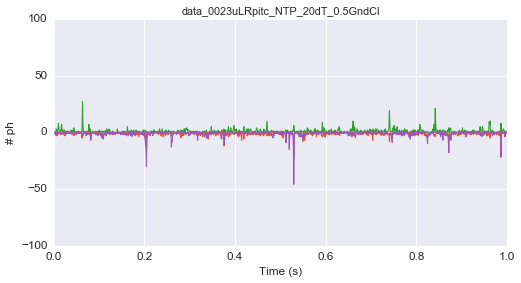

In [18]:
dplot(d, timetrace);

Here, `dplot` is a generic wrapper (the same for all plots)
that takes care of setting up the figure, title and axis 
(in the multispot case `dplot` creates multi-panel plot).
The second argument, `timetrace`, is the actual plot function. 
All the eventual additional arguments passed to `dplot` are, 
in turn, passed to the plot function (e.g. `timetrace`).

If we look at the documentation for [`timetrace`](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.timetrace)
function we notice that it accepts a long list of arguments.
In python, when an argument is not specified, it will take the default
value specified in the function definition (see previus link).

As an example, to change the bin size (i.e. duration) of the timetrace histogram,
we can look up in the [`timetrace` documentation](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.timetrace)
and find that the argument we need to modify is `binwidth`
(we can also see that the default value is `0.001` seconds).
We can then re-plot the timetrace using a bin of 0.5 ms:

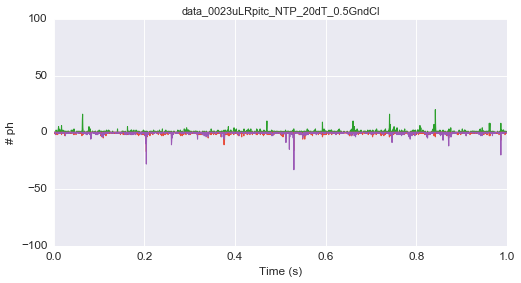

In [19]:
dplot(d, timetrace, binwidth=0.5e-3);

The timetrace is **computed** between `tmin` and `tmax` (by default 0 and 200s),
but as you can see is displayed only between 0 an 1 second, just because these
are the default x-axis limits. The axis limits can be changes by using the
standard matplotlib command `plt.xlim()`.
On the other hand, to change the range where the timetrace is **computed**,
we pass the additional arguments `tmin` and `tmax` as follows:

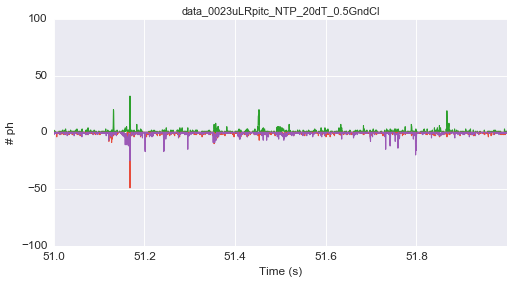

In [20]:
dplot(d, timetrace, binwidth=0.5e-3, tmin=50, tmax=150)
plt.xlim(51, 52);

When using FRETBursts in a notebook, all plots are static by default.
This is because we use the so called `inline` backend of matplotlib.
If you want to manipulate figures interactively, you can switch
to the interactive `notebook` backend with:

```
%matplotlib notebook
```

to go back to inline use:


```
%matplotlib inline
```

**NOTE**: Currently, the `notebook` backend is incompatible with the QT backend. 
If in a session you activate the `notebook` backend, then switching to the QT backend requires 
restarting the notebook. Conversely, you can switch between `inline` and `notebook` 
or between `inline` and `qt4` backends in the same session wihtou issues.

> ### See also:
>
> - [bpl.timetrace](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.timetrace)
>    function documentation
> - [bpl.ratetrace](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.ratetrace)
>   function documentation
> - [Intensity timetrace and Rate-timetrace](#Intensity-timetrace-and-Rate-timetrace), a later section in this tutorial.

# Background estimation

As a first step of the analysis, we need to estimate the background. 
The assumption is that the background is a Poisson process and therefore 
the corresponding inter photon delays are exponentially distributed. Since the 
background can change during the measurement, a new estimation is 
computed every `time_s` seconds (this time is called the *background period*).

The inter photon delay distribution contains 
both single-molecule signal and background, the latter being the only one we are interested in
and the former being in general much shorter. Therefore, a threshold is needed
to discriminate between the exponential tail and the single-molecule peak.

Choosing a threshold and fitting the exponential tail are two 
different problems.
FRETBursts provides several ways to specify the minimum threshold 
and different functions to fit the exponential tail.

We will go over three different methods in increasing order of complexity (and recommendability)

For more information see:

- Documentation for [`Data.calc_bg()`](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.calc_bg)
- Documentation for [`background` (e.g. `bg`) module](http://fretbursts.readthedocs.org/en/latest/background.html)
- Documentation for [`exp_fitting` module](http://fretbursts.readthedocs.org/en/latest/background.html#module-fretbursts.fit.exp_fitting).

## Single threshold

Let start with a standard Maximum Likelihood (ML) 
background fit with a minimum tail threshold of 500μs:

In [21]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=500)

 - Calculating BG rates ... 

[DONE]


We can look at how the fit looks with:

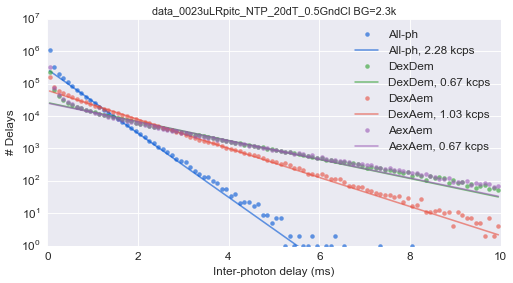

In [22]:
dplot(d, hist_bg, show_fit=True)

Note that the fits are not very good. This is understandable because 
we used a single threshold for all the photon streams, each one
having a quite different background.

## Multiple thresholds

To improve the fit, we can try specifying a threshold for each channel.
This method is bit ad-hoc but it may work well when the 
thresholds are properly choosen.

In [23]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us=(800, 4000, 1500, 1000, 3000))

 - Calculating BG rates ... 

[DONE]


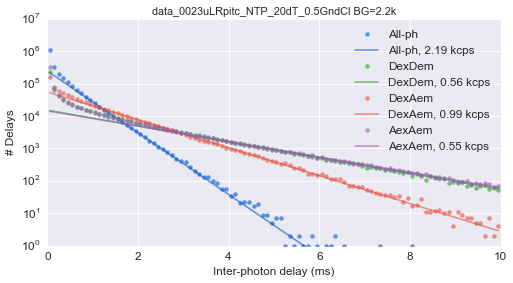

In [24]:
dplot(d, hist_bg, show_fit=True);

For ALEX measurements, the tuple passed to
`tail_min_us` in order to define the thresholds needs to contain  
5 values corresponding the 5 distinct photon streams (the all-photon stream
+ the 4 base alternation streams).
The order of these 5 values need to match the order of photon streams in
the `Data.ph_streams` attribute:

In [25]:
d.ph_streams

[Ph_sel(Dex='DAem', Aex='DAem'),
 Ph_sel(Dex='Dem', Aex=None),
 Ph_sel(Dex='Aem', Aex=None),
 Ph_sel(Dex=None, Aex='Dem'),
 Ph_sel(Dex=None, Aex='Aem')]

## Automatic threshold

Finally, is possible to let FRETBursts infer the threshold automatically with:

In [26]:
d.calc_bg(bg.exp_fit, time_s=1000, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


Which results in the following fit plot:

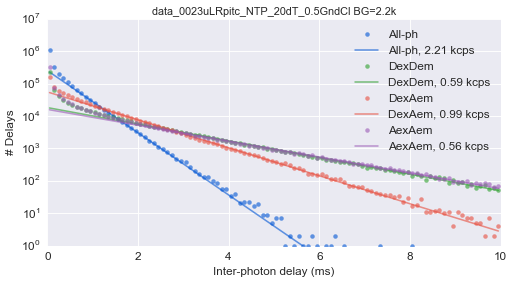

In [27]:
dplot(d, hist_bg, show_fit=True);

Under the hood, this method estimates the threshold 
automatically according to this formula:

    threshold_auto = F_bg / coarse_background_rate

where `F_bg` is the fit function input argument (by default 1.7)
and `coarse_background_rate` is an initial background estimation
performed with fixed threshold. This method is concemptually an
iterative method to compute the threshold that is stopped
after the second iteration (this is usually more than enough for
accurate estimates).

Of the three methods here described, the latter is the recommended one 
since it works well and without user intervention in 
a wide range of experimental conditions.

## Background timetrace

It is a good practice to monitor background rates as a function of time.
Here, we compute background in adjacent 30s windows (called *background periods*)
and plot the estimated rates as a function of time.

In [28]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


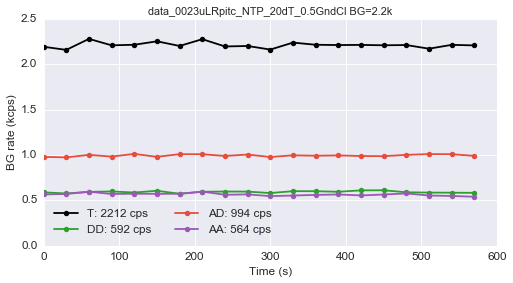

In [29]:
dplot(d, timetrace_bg)

## Getting the background rates

The background rates are stored in `Data()` attributes 
`bg`, `bg_dd`, `bg_ad`, `bg_aa`. These contain all the 
fitted background rates for each channel and period.

We can also get the average background for each channel:

In [30]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_da, d.rate_aa

([2212.6520253589342],
 [592.2024909931622],
 [994.39404281480734],
 [74.737849340892041],
 [564.86449968607053])

# Burst analysis

The first step of burst analysis is the burst search. 

We will use the sliding-window algorithm on all photons. Note 
that "all photons", as mentioned before, means all photons selected in the 
alternation histogram.
An important variation compared to the classical sliding-windows 
is that the threshold-rate for burst start is computed as 
a function of the background and changes when the background
changes during the measurement.

To perform a burst search evaluating the photon rate with 
10 photons (`m=10`), and selecting a minimum rate 6 times larger than 
the background rate (F=6) calculated with all photons (default):

In [31]:
d.burst_search(L=10, m=10, F=6)

 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


The previous command performs the burst search, corrects 
the bursts sizes for background, spectral leakage and direct excitation,
and computes $\gamma$-corrected FRET and Stoichiometry. 

See the 
[`burst_search` documentation](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.burst_search) for more details.

We can plot the resulting FRET histogram using the following command:

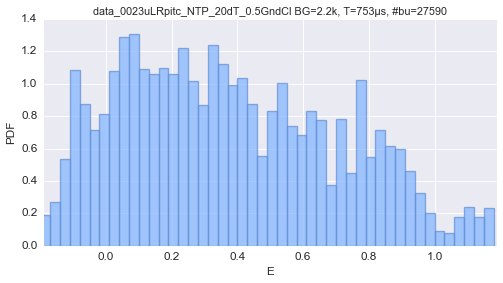

In [32]:
dplot(d, hist_fret);

All pre-defined plots follow this pattern: 
call the generic `dplot()` function, passing 2 parameters:

- the measurement data (`d` in this case) 
- the plot function (`hist_fret`)

In some case we can add other optional parameters to tweak the plot.

All plot functions start with `hist_` for histograms, 
`scatter_` for scatter-plots  or `timetrace_` for plots as a function 
of measurement time. You can use autocompletion to find all 
plot function or you can look in `bursts_plot.py` where 
all plot functions are defined.

Instead of `hist_fret` we can use `hist_fret_kde` to add a [KDE](http://en.wikipedia.org/wiki/Kernel_density_estimation) overlay. Also, we can plot a **weighted histogram** by passing an additional parameter `weights`:

 - Overwriting the old E_fitter object with the new weights.


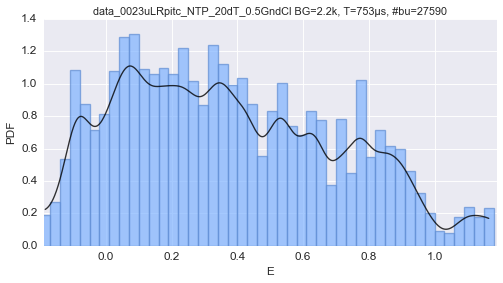

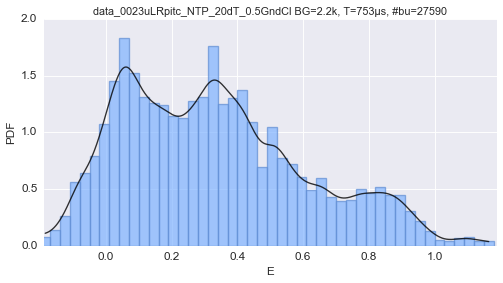

In [33]:
dplot(d, hist_fret, show_kde=True);
dplot(d, hist_fret, show_kde=True, weights='size');

You can experiment with different weighting schema (for all 
supported weights see `get_weigths()` function in `fret_fit.py`).

## Burst selection

When we performed the burst search, we specified `L=10` without 
explaining what this parameter means. *L* is traditionally the minimum size 
(number of photons) for a burst: smaller bursts will be rejected. 
By setting L=m (10 in this case) we are deciding to not discard 
any burst (because the smallest detected burst has at least *m* counts). 

Selecting the bursts in a second step, by applying a minimum burst size criterion, 
results in a more accurate and unbiased selection.

For example, we can select bursts with more than 30 photons (after 
background, gamma, leakage and direct excitation corrections)
and store the result in a new
`Data()` variable `ds`:

In [34]:
ds = d.select_bursts(select_bursts.size, th1=30)

By defaults the burst size includes donor and acceptor photons 
during donor excitation. To add acceptor photons during 
acceptor excitation (`naa`), we add the parameter `add_naa=True`:

In [35]:
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=30)

Similar to plot functions, all selection functions 
are defined in `select_bursts.py` and you can access them by typing 
`select_bursts.` and using the TAB key for autocompletion. 

> **See also:** 
> * [Burst selection](http://fretbursts.readthedocs.org/en/latest/burst_selection.html) in the documentation. 
> In particular the function [`select_bursts.size`](http://fretbursts.readthedocs.org/en/latest/burst_selection.html#fretbursts.select_bursts.size) and [`Data.select_bursts`](http://fretbursts.readthedocs.org/en/latest/data_class.html#fretbursts.burstlib.Data.select_bursts).

To replot the FRET histogram after selection (note that now 
we are passing `ds` to the plot function):

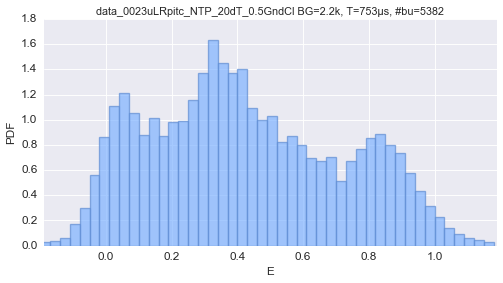

In [36]:
dplot(ds, hist_fret);

Note how the histogram exhibits much more clearly defined peaks after burst selection. 

## Histogram fitting and plotting style

Under the hood the previous `hist_fret` plot creates a `MultiFitter` 
object for $E$ values. This object, stored as `ds.E_fitter`, operates
on multi-channel data and computes the histogram, KDE and can fit 
the histogram with a model ([lmfit.Model](http://lmfit.github.io/lmfit-py/model.html)).

Now, just for illustration purposes, we fit the previous histogram with 3 Gaussians, using the already created `ds.E_fitter` object:

In [37]:
ds.E_fitter.fit_histogram(mfit.factory_three_gaussians(), verbose=False)

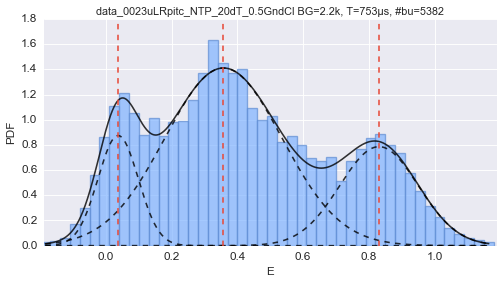

In [38]:
dplot(ds, hist_fret, show_model=True);

The bin width can be changed with `binwidth` argument. Alternatively,
an arbitrary array of bin edges can be passed in `bins` 
(overriding `binwidth`).

We can customize the appearance of this plot (type 
`hist_fret?` for the complete set of arguments). 

For example to change from a bar plot to a line-plot 
we use the `hist_style` argument:

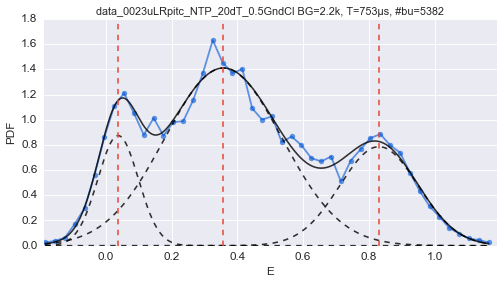

In [39]:
dplot(ds, hist_fret, show_model=True, hist_style='line')

We can customize the line-plot, bar-plot, the model 
plot and the KDE plot by passing dictionaries with matplotlib 
style. The name of the arguments are:

- `hist_plot_style`: style for the histogram line-plot
- `hist_bar_style`: style for the histogram bar-plot
- `model_plot_style`: style for the model plot
- `kde_plot_style`: style for the KDE plot

As an example:

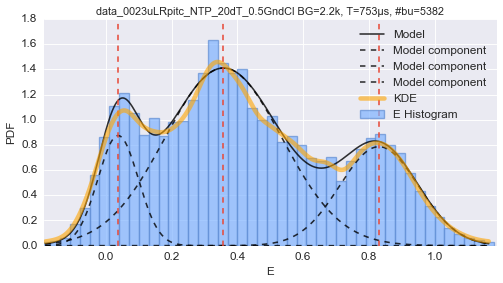

In [40]:
dplot(ds, hist_fret, show_model=True, hist_style='bar', show_kde=True,
      kde_plot_style = dict(linewidth=5, color='orange', alpha=0.6),
      hist_plot_style = dict(linewidth=3, markersize=8, color='b', alpha=0.6))
plt.legend();

# Other plots

Similarly, we can plot the burst size using all photons 
(type `hist_size?` to learn about all plot options):

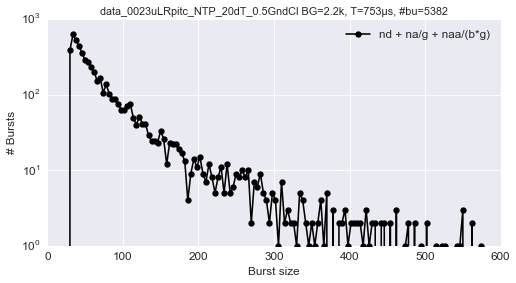

In [41]:
dplot(ds, hist_size, add_naa=True);

Or plot the burst size histogram for the different components:

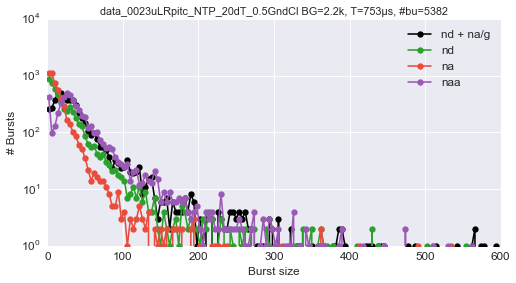

In [42]:
dplot(ds, hist_size_all);

> **NOTE:** The previous plot may generate a benign warning 
> due to the presence of zeroes when switching to log scale. Just ignore it.

A scatterplot of Size *vs* FRET is created by:

(-1, 2)

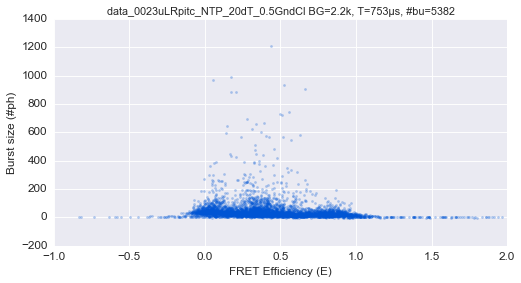

In [43]:
dplot(ds, scatter_fret_nd_na)
xlim(-1, 2)

# Study of different populations

## Removing multi-mers

We can further select only bursts smaller than 300 photons 
to get rid of multi-molecule events:

In [44]:
ds2 = ds.select_bursts(select_bursts.size, th2=300)

and superimpose the two histograms before and after selection to see the difference:

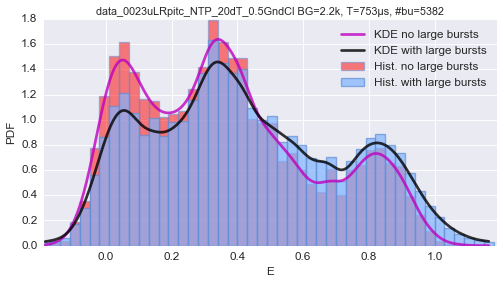

In [45]:
ax = dplot(ds2, hist_fret, hist_style='bar', show_kde=True, 
              hist_bar_style = dict(facecolor='r', alpha=0.5, 
                                    label='Hist. no large bursts'),
              kde_plot_style = dict(lw=3, color='m', 
                                    label='KDE no large bursts'))
dplot(ds, hist_fret, ax=ax, hist_style='bar', show_kde=True,
      hist_bar_style = dict(label='Hist. with large bursts'),
      kde_plot_style = dict(lw=3, label='KDE with large bursts'))
plt.legend();

> **NOTE:** It is not necessarily true that bursts with more that 300 photons 
> represents multiple molecules. 
> To asses the valididty of this assumption it can be useful to 
> plot the peak count rates in each burst. See `hist_burst_phrate` 
> for this kind of plot.

## Fit and plot peak positions

We can find the KDE peak position in a range (let say 0.2 ... 0.6):

In [46]:
ds.E_fitter.find_kde_max(np.r_[0:1:0.0002], xmin=0.2, xmax=0.6)

and plot it with `show_kde_peak=True`, we also use `show_fit_value=True` to show a box with the fitted value:

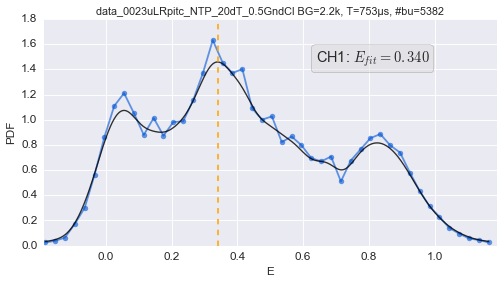

In [47]:
dplot(ds, hist_fret, hist_style='line', 
      show_fit_value=True, 
      show_kde=True, show_kde_peak=True);

Instead of using the KDE, we can use the peak position as fitted from a gaussian model. 

In [48]:
ds.E_fitter.fit_histogram(mfit.factory_three_gaussians(), verbose=False)

To select which peak to show we use `fit_from='p1_center'`:

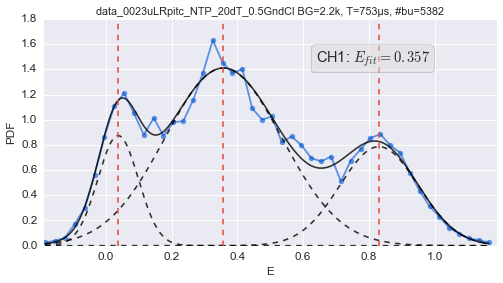

In [49]:
dplot(ds, hist_fret, hist_style='line', 
      show_fit_value=True, fit_from='p2_center', 
      show_model=True);

The string `'p2_center'` is the name of the parameter of the 
gaussian fit that we want to show in the text box. To see all 
the parameters of the model we look in:

In [50]:
ds.E_fitter.params  # <-- pandas DataFrame, one row per channel

,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma,p3_amplitude,p3_center,p3_sigma
0,0.235592,0.830905,0.119578,0.629798,0.357341,0.178132,0.135013,0.0368783,0.0616214


## ALEX plots

We can create a simple E-S scatter plot with `scatter_alex`:

/Users/anto/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/anto/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['mew', 'markeredgewidth'] which are all aliases for 'markeredgewidth'.  Kept value from 'markeredgewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/anto/miniconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs ['mec', 'markeredgecolor'] which are all aliases for 'markeredgecolor'.  Kept value from 'markeredgecolor'
  seen=seen, canon=canonical, used=seen[-1]))


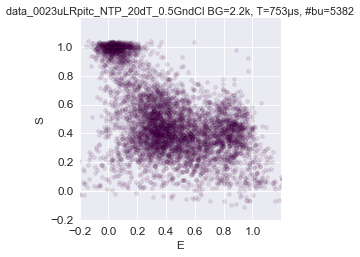

In [51]:
dplot(ds, scatter_alex, figsize=(4,4), mew=1, ms=4, mec='black', color='purple');

We can also plot the ALEX histogram with a scatterplot overlay using `hist2d_alex`:

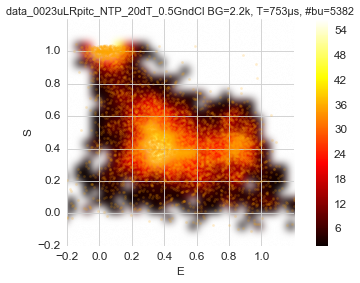

In [52]:
dplot(ds, hist2d_alex);

Finally we can also plot an ALEX histogram and marginals 
(joint plots) as follow (for more options see: 
[Example - usALEX histogram](Example - usALEX histogram.ipynb)):

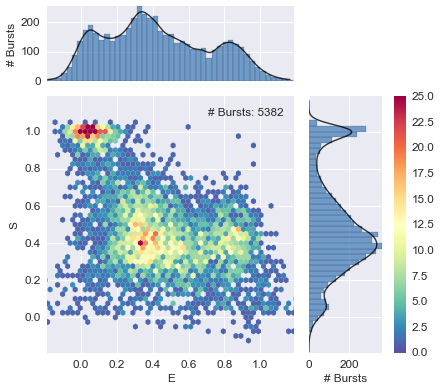

In [53]:
alex_jointplot(ds);

To get rid of the large donor-only population, we can simply 
select bursts with at least 10 photons in the acceptor channel 
(during acceptor excitation). At the same time,
with a burst size selection using Dex photons we get rid
of the A-only population:

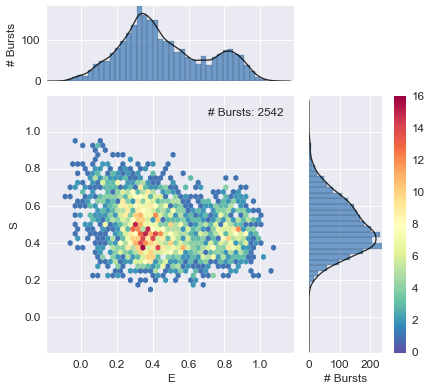

In [54]:
ds = d.select_bursts(select_bursts.size, th1=20)
ds2 = ds.select_bursts(select_bursts.naa, th1=10)
alex_jointplot(ds2);

As you can see, we remained with only the FRET sub-populations.

See next sections show how to select a region on the E/S 
histogram to isolate a subpopulation.

## Graphical selection of an E-S region
<br>
<div class="alert alert-warning">
The graphical selection of E-S regions requires a local FRETBursts installation.
Therefore the commands below are commented by default.
<br><br>
If you have a local installation and you want to try commands below,
please uncomment (i.e. remove the inital <code>#</code>) from the lines
containing the <code>%matplotlib</code> command.
</div>


To select bursts graphically, we need to open the ALEX histogram 
in a new (QT) window, drag the mouse to define a selection and 
have it printed here in the notebook.

Here we describe how to do it in 3 steps.

**Step 1** Switch the plot modality to QT (i.e. opens graphs in a separate window):

In [55]:
# Switches to open plot in external window
#%matplotlib qt

**Step 2** Plot the E-S histogram in an external windows. There you can
use the mouse to select a region:

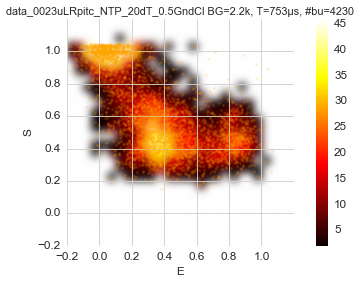

In [56]:
# ALEX histogram with GUI selection enabled
dplot(ds, hist2d_alex, gui_sel=True)

The region selection is printed above.

**Step 3** Restore the normal inline plotting (no more external windows).

In [57]:
# Switch back to show plots inline in the notebook
#%matplotlib inline

## Selection bursts by E-S values

To apply a selection based on E-S values, 
we can paste the values obtained from the previous plot
(or we can type them in manually).

The selection function used here is `select_bursts.ES`.
The same *E* and *S* boundaries can define either a rectangular 
or an elliptical selection by using 
respectively `rect=True` or `rect=False`. 
Here we use the elliptical selection:

In [58]:
roi = dict(E1=-0.07, E2=1.17, S1=0.18, S2=0.70, rect=False)
d_fret_mix = ds.select_bursts(select_bursts.ES, **roi)

By plotting the FRET histogram we can double check that 
the selection has been applied:

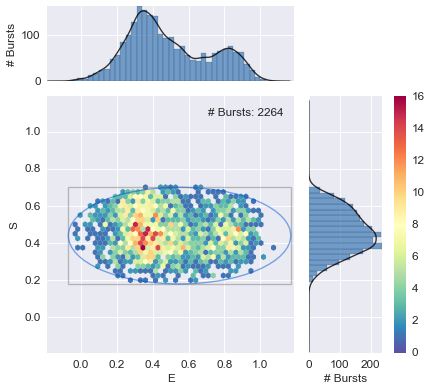

In [59]:
g = alex_jointplot(d_fret_mix)
bpl.plot_ES_selection(g.ax_joint, **roi);

Now we can further separate high- and low FRET sub-populations. 

In [60]:
roi_high_fret = dict(E1=0.65, E2=1.09, S1=-0.13, S2=0.96)
d_high_fret = d_fret_mix.select_bursts(select_bursts.ES, **roi_high_fret)
roi_low_fret = dict(E1=-0.19, E2=0.64, S1=-0.05, S2=0.92)
d_low_fret = d_fret_mix.select_bursts(select_bursts.ES, **roi_low_fret)

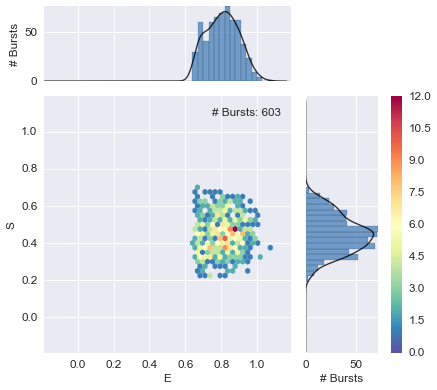

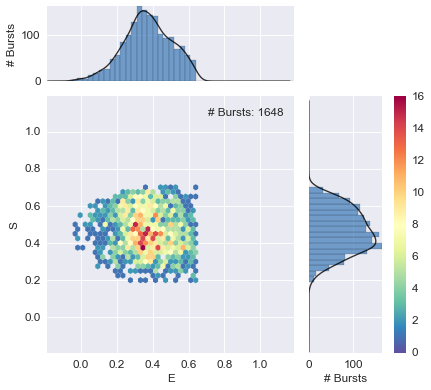

In [61]:
alex_jointplot(d_high_fret);
alex_jointplot(d_low_fret);

We can for example compute the ratio of high- and low-fret bursts:

In [62]:
d_low_fret.num_bursts / d_high_fret.num_bursts

array([ 2.73300166])

## Burst Width analysis

To plot a burst-width histogram, we use `hist_width` instead of `hist_fret`:

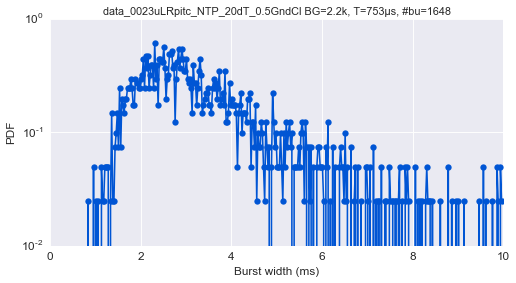

In [63]:
dplot(d_low_fret, hist_width)

To use a larger bin size, plots two sub-populations (in different color) and add a legend:

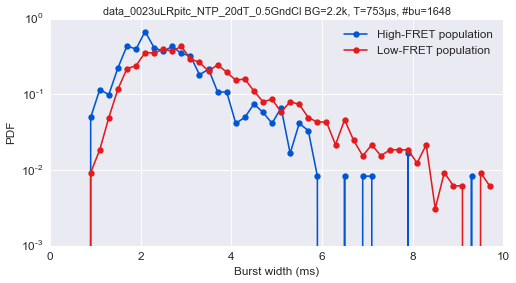

In [64]:
ax = dplot(d_high_fret, hist_width, bins=(0, 10, 0.2))
dplot(d_low_fret, hist_width, bins=(0, 10, 0.2), ax=ax)
plt.legend(['High-FRET population', 'Low-FRET population']);

Finally, we compute the mean burst width for each subpopulation:

In [65]:
millisec = d.clk_p * 1e3
mean_b_width_low_fret  = d_low_fret.mburst[0].width.mean() * millisec
mean_b_width_high_fret = d_high_fret.mburst[0].width.mean() * millisec

print('Mean burst width: %.1f ms (high-fret), %.1f (low-fret)' % 
      (mean_b_width_high_fret, mean_b_width_low_fret))

Mean burst width: 2.7 ms (high-fret), 3.5 (low-fret)


# FRET fit: in-depth example

We can fit a FRET distribution to any model. For example, 
we will fit the FRET selection (2 FRET sub-populations) with 2 Gaussians. 
The fitting model is a [`Model` object](http://lmfit.github.io/lmfit-py/model.html) 
from the [`lmfit` library](http://lmfit.github.io/lmfit-py/).

The first step, previously performed implicitely by the `hist_fret()`
plot function, is to create a [MultiFitter](http://fretbursts.readthedocs.org/en/latest/mfit.html#the-multifitter-class) 
object for $E$ and/or $S$, by calling [bext.bursts_fitter()](http://fretbursts.readthedocs.org/en/latest/plugins.html?highlight=bursts_fitter#fretbursts.burstlib_ext.bursts_fitter). 
With `MultiFitter` objects, we can compute histograms, 
KDEs and fit the histogram in one single step, as in the following example:

In [66]:
E_fitter = bext.bursts_fitter(d_fret_mix, 'E', binwidth=0.03, bandwidth=0.03, 
                              model=mfit.factory_two_gaussians())
S_fitter = bext.bursts_fitter(d_fret_mix, 'S', binwidth=0.03, bandwidth=0.03, 
                              model=mfit.factory_gaussian())

However if we want to modify the model (for example to add a 
constrain) we need to perform the fit in a second step. 
To skip the fitting, we simply avoid passing a `model`:

In [67]:
E_fitter = bext.bursts_fitter(d_fret_mix, 'E', binwidth=0.03, bandwidth=0.03)
S_fitter = bext.bursts_fitter(d_fret_mix, 'S', binwidth=0.03, bandwidth=0.03) 

Now we create a model and initialize the parameters 
using [`mfit.factory_two_gaussians()`](http://fretbursts.readthedocs.org/en/latest/mfit.html#fretbursts.mfit.factory_two_gaussians) 
(see [Model factory functions](http://fretbursts.readthedocs.org/en/latest/mfit.html#model-factory-functions) 
for a list of pre-defined models in FRETBursts):

In [68]:
model = mfit.factory_two_gaussians(add_bridge=True)

We can see the list of parameters, initial values and constraints:

In [69]:
model.print_param_hints()

Name             Value      Min      Max     Vary    Expr    
br_amplitude    0.0001        0      inf     True    
br_center1         nan        0      inf     True    p1_center
br_center2         nan        0      inf     True    p2_center
br_sigma1          nan        0      inf     True    p1_sigma
br_sigma2          nan        0      inf     True    p2_sigma
p1_amplitude         1     0.01      inf     True    
p1_center          0.1       -1        2     True    
p1_fwhm            nan     -inf      inf     True    2.3548200*p1_sigma
p1_height          nan     -inf      inf     True    0.3989423*p1_amplitude/max(1.e-15, p1_sigma)
p1_sigma          0.03     0.01      0.2     True    
p2_amplitude         1     0.01      inf     True    
p2_center          0.9       -1        2     True    
p2_fwhm            nan     -inf      inf     True    2.3548200*p2_sigma
p2_height          nan     -inf      inf     True    0.3989423*p2_amplitude/max(1.e-15, p2_sigma)
p2_sigma          0.03  

We can change initial values and/or constrains (bounds):

In [70]:
model.set_param_hint('p1_center', value=0.3, min=-0.1, max=0.6)
model.set_param_hint('p2_center', value=0.85, min=0.5, max=1.1)
model.print_param_hints()

Name             Value      Min      Max     Vary    Expr    
br_amplitude    0.0001        0      inf     True    
br_center1         nan        0      inf     True    p1_center
br_center2         nan        0      inf     True    p2_center
br_sigma1          nan        0      inf     True    p1_sigma
br_sigma2          nan        0      inf     True    p2_sigma
p1_amplitude         1     0.01      inf     True    
p1_center          0.3     -0.1      0.6     True    
p1_fwhm            nan     -inf      inf     True    2.3548200*p1_sigma
p1_height          nan     -inf      inf     True    0.3989423*p1_amplitude/max(1.e-15, p1_sigma)
p1_sigma          0.03     0.01      0.2     True    
p2_amplitude         1     0.01      inf     True    
p2_center         0.85      0.5      1.1     True    
p2_fwhm            nan     -inf      inf     True    2.3548200*p2_sigma
p2_height          nan     -inf      inf     True    0.3989423*p2_amplitude/max(1.e-15, p2_sigma)
p2_sigma          0.03  

Finally, we fit the histogram with one 
of the [supported minimization methods](http://lmfit.github.io/lmfit-py/fitting.html#fit-engines-label) 
(the default is least-squares):

In [71]:
E_fitter.fit_histogram(model=model, verbose=False)     # default method is 'leastsq'
#E_fitter.fit_histogram(model=model, method='nelder')  # example using simplex method

To plot the model with the fitted parameters on top of the FRET 
histogram, we add `show_model=True` as seen before:

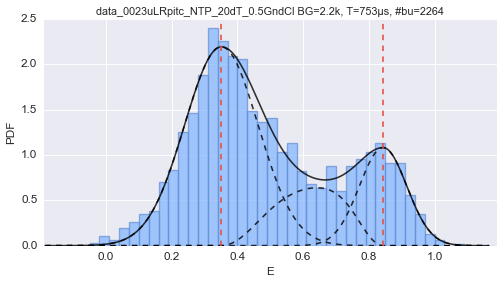

In [72]:
dplot(d_fret_mix, hist_fret, show_model=True);

The fitting results of `lmfit` models are stored in [lmfit.ModelResult](https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class) objects. In FRETBursts, these objects are available in `MultiFitter.fit_res`:

In [73]:
E_fitter.fit_res[0]

Here the `[0]` indicates CH=0. This index is used in multispot measurements, in which 
there are several channels.

The values of the fitted parameters are available in the `best_values` 
dictionary:

In [74]:
results = E_fitter.fit_res[0]

In [75]:
results.params.pretty_print(columns=['value'])

Name             Value
br_amplitude     0.676
br_center1      0.3511
br_center2      0.8434
br_sigma1        0.112
br_sigma2      0.07232
p1_amplitude    0.6158
p1_center       0.3511
p1_fwhm         0.2637
p1_height        2.193
p1_sigma         0.112
p2_amplitude    0.1961
p2_center       0.8434
p2_fwhm         0.1703
p2_height        1.082
p2_sigma       0.07232


We can also print a complete report of fitted parameters 
including reduced $\chi^2$, error ranges 
($\pm 1 \sigma$) and correlations:

In [76]:
print(results.fit_report(min_correl=0.5))

[[Model]]
    ((Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_')) + Model(bridge_function, prefix='br_'))
[[Fit Statistics]]
    # function evals   = 108
    # data points      = 46
    # variables        = 7
    chi-square         = 0.434
    reduced chi-square = 0.011
    Akaike info crit   = -200.555
    Bayesian info crit = -187.755
[[Variables]]
    p1_center:      0.35108078 +/- 0.004580 (1.30%) (init= 0.3)
    p1_amplitude:   0.61579116 +/- 0.021607 (3.51%) (init= 1)
    p1_sigma:       0.11200392 +/- 0.004505 (4.02%) (init= 0.03)
    p2_center:      0.84336380 +/- 0.010490 (1.24%) (init= 0.85)
    p2_amplitude:   0.19608694 +/- 0.023684 (12.08%) (init= 1)
    p2_sigma:       0.07232435 +/- 0.009248 (12.79%) (init= 0.03)
    br_center1:     0.35108078 +/- 0.004580 (1.30%)  == 'p1_center'
    br_center2:     0.84336380 +/- 0.010490 (1.24%)  == 'p2_center'
    br_sigma1:      0.11200392 +/- 0.004505 (4.02%)  == 'p1_sigma'
    br_sigma2:      0.07232435 +/- 0.009248 (1

To customize the printed report, see [lmfit.fit_report()](https://lmfit.github.io/lmfit-py/fitting.html?highlight=fit_report#getting-and-printing-fit-reports) docs.

We can also take a look at the initial parameters:

In [77]:
results.init_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr
br_amplitude    0.0001        0      inf     None     True     None
br_center1         0.3        0      inf     None    False p1_center
br_center2        0.85        0      inf     None    False p2_center
br_sigma1         0.03        0      inf     None    False p1_sigma
br_sigma2         0.03        0      inf     None    False p2_sigma
p1_amplitude         1     0.01      inf     None     True     None
p1_center          0.3     -0.1      0.6     None     True     None
p1_fwhm        0.07064     -inf      inf     None    False 2.3548200*p1_sigma
p1_height         13.3     -inf      inf     None    False 0.3989423*p1_amplitude/max(1.e-15, p1_sigma)
p1_sigma          0.03     0.01      0.2     None     True     None
p2_amplitude         1     0.01      inf     None     True     None
p2_center         0.85      0.5      1.1     None     True     None
p2_fwhm        0.07064     -inf      inf     None    False 2.3548200

We can compute more accurate confidence-intervals (note that 
it can take several seconds, 
see [lmfit docs](https://lmfit.github.io/lmfit-py/confidence.html) 
for the method details):

In [78]:
ci = results.conf_interval()
lmfit.report_ci(ci)

                 99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 p1_center   :  -0.01382  -0.00894  -0.00446   0.35108  +0.00463  +0.00964  +0.01561
 p1_amplitude:  -0.06864  -0.04463  -0.02234   0.61579  +0.02332  +0.04873  +0.07911
 p1_sigma    :  -0.01454  -0.00954  -0.00482   0.11200  +0.00511  +0.01076  +0.01757
 p2_center   :  -0.03534  -0.02150  -0.01035   0.84336  +0.01031  +0.02169  +0.03557
 p2_amplitude:  -0.07419  -0.04545  -0.02209   0.19609  +0.02274  +0.04774  +0.07868
 p2_sigma    :  -0.02561  -0.01627  -0.00821   0.07232  +0.00904  +0.01961  +0.03343
 br_amplitude:  -0.29926  -0.16213  -0.07174   0.67595  +0.06246  +0.12069  +0.18022


Finally, FRETBursts's 
[MultiFitter object](http://fretbursts.readthedocs.org/en/latest/mfit.html#the-multifitter-class) 
(e.g. `E_fitter`) stores the fitted parameters in `E_fitter.params` as pandas DataFrame:

In [79]:
E_fitter.params

,br_amplitude,br_center1,br_center2,br_sigma1,br_sigma2,p1_amplitude,p1_center,p1_sigma,p2_amplitude,p2_center,p2_sigma
0,0.675953,0.351081,0.843364,0.112004,0.0723244,0.615791,0.351081,0.112004,0.196087,0.843364,0.0723244


For more information on fitting see:

- [FRETBursts: Fit Framework](http://fretbursts.readthedocs.org/en/latest/fit.html)
- [lmfit Documentation](http://cars9.uchicago.edu/software/python/lmfit/index.html).

# Exporting Data

To export data computed by FRETBursts, you need to find first where 
the data is stored or, for data computed on fly, which function/method 
is used to computed it. 

Most data computed by FRETBursts is stored in the `Data` object
(see the [Data docs](http://fretbursts.readthedocs.org/en/latest/data_class.html) for the list of attributes).
For example:

- background data is stored in `Data.bg_*` attributes (see [Getting the background rates](#Getting-the-background-rates) in this notebook)
- corrected burst counts are stored in `Data.nd`, `Data.na`, `Data.naa`
- timestamps are stored in `Data.ph_times_m`

All these attributes are list of arrays, one per excitation spot. 
This means that, even for single-spot data, we need to use indexing (`[0]`)
to obtain the array. For example:

In [80]:
d.bg_dd[0]

array([ 588.03160615,  575.80659043,  592.80446739,  598.31423419,
        585.87249291,  605.7735346 ,  572.17891612,  594.32681543,
        596.83862786,  596.29018019,  580.1894661 ,  601.1553107 ,
        600.54652031,  594.32986899,  609.8467461 ,  610.82005227,
        588.64537525,  585.42494226,  584.14560639,  582.70846621])

Any numpy array can be saved to disk with the method `.tofile()`. For example:

In [81]:
d.bg_dd[0].tofile('bg_dd.csv', sep=',')

## Exporting burst data

Part of burst data is stored in `Data` attributes (`mburst`, `nd`, `na`, `naa`)
and part is computed on fly (duration, raw counts, etc.).

To put all burst data in a single "table" (a `pandas.DataFrame`), one row
per burst, we can use `bext.burst_data`:

In [82]:
bursts = bext.burst_data(ds)
bursts

,E,S,bp,na,naa,nd,nda,nt,size_raw,t_end,t_start,width_ms
0,-0.074447,0.932490,0,-2.077267,2.020074,29.979787,-0.140691,29.922595,37,0.064491,0.062756,1.734962
1,0.974802,0.409378,0,19.955724,29.534963,0.515844,-0.066767,50.006531,53,0.204703,0.203880,0.823350
2,0.869525,0.580753,0,19.177914,15.922023,2.877705,-0.154769,37.977642,43,0.377019,0.375110,1.908562
3,0.725893,0.338219,0,21.156958,57.029083,7.989166,-0.139398,86.175207,93,0.530547,0.528828,1.719013
4,0.154575,0.860533,0,3.836323,4.022348,20.982154,-0.140365,28.840825,35,0.741413,0.739682,1.730937
...,...,...,...,...,...,...,...,...,...,...,...,...
4225,0.920192,0.371789,19,31.533749,57.903602,2.734925,0.711153,92.172275,104,599.548232,599.544345,3.887150
4226,0.731638,0.408368,19,37.905659,75.059754,13.903641,-0.267332,126.869054,139,599.551430,599.547832,3.597612
4227,0.584799,0.257430,19,17.552035,86.576289,12.461737,-0.196163,116.590062,127,599.573195,599.570555,2.639850
4228,0.798634,0.342328,19,29.771621,71.617776,7.506562,-0.190446,108.895959,118,599.729008,599.726445,2.562925


> **NOTE**: For multi-spot data use the `ich` argument to get burst data
> for the different spots.

This table (as any `pandas.DataFrame`) can be saved in a CSV text file with:

In [83]:
bursts.to_csv('bursts.csv')

# Intensity timetrace and Rate timetrace

For an initial inspection of a data file, it is common to compute an intensity *timetrace* plot (or timetrace for short). 
We also can compute a similar plot called *ratetrace*, which does not bin counts 
but shows the instantaneous count rate. In both cases, it is convenient to scroll 
along the plot interactively.

In FRETBursts, the two *timetrace* and *ratetrace* plots support 
interactive scrolling. We just need to switch from the inline backend 
to QT, as we did before. 

<br>
<div class="alert alert-warning">
The graphical scrolling of timetraces requires a local FRETBursts installation.
Therefore the commands below are commented by default.
<br><br>
If you have a local installation and you want to try commands below,
please uncomment them by removing the inital <code>#</code>.
</div>


Here are the corresponding commands:

In [84]:
#%matplotlib qt

In [85]:
#dplot(ds, ratetrace, scroll=True, bursts=True)

In [86]:
#dplot(ds, timetrace, tmax=600, scroll=True, bursts=True)

In [87]:
#%matplotlib inline

Note that, to save memory, the previous plots stops will show the first 200 s
of measurement.
For both `timetrace` and `ratetrace`, you can extent (or reduce) the plotted 
region passing the `tmin` and `tmax` arguments (values in seconds).

> ### Related documentation:
>
> - [bpl.timetrace](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.timetrace)
> - [bpl.ratetrace](http://fretbursts.readthedocs.org/en/latest/plots.html#fretbursts.burst_plot.ratetrace)

<br>
<div class="alert alert-success">
This ends of the tutorial.
</div>

----

*Please send feedback and/or question by opening a new [GitHub Issue](https://github.com/tritemio/FRETBursts/issues).*